In [1]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPForImageClassification, CLIPProcessor, CLIPModel
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, RandomCrop, Normalize, ToPILImage
import matplotlib.pyplot as plt
import scipy 
import torchvision
from torch.utils.data import DataLoader

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_rgb = torchvision.transforms.Lambda(lambda img: img.convert("RGB"))
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
transform = Compose([
    transform_rgb,
    ToTensor(),
    # RandomCrop((128, 128)),
    Resize((224, 224)),
    # Normalize(mean=imagenet_mean, std=imagenet_std),
])

# There is something wrong with torchvision.datasets.Caltech101
# So i download the dataset and unzip it
dataset = datasets.Caltech101(
    root="data",
    download=False,
    transform=transform,
)


train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16, 3, 224, 224])
emu


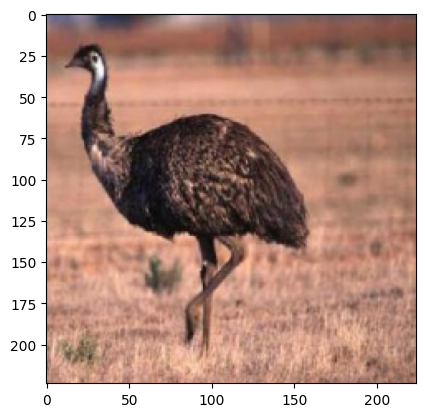

In [3]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

x_train, y_train = next(iter(train_loader))

print(f"Feature batch shape: {x_train.size()}")
print(f"Labels batch shape: {x_train.size()}")
img = x_train[0]
plt.imshow(img.permute(1, 2, 0)) # Convert from CHW to HWC
print(dataset.categories[y_train[0]])

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')

In [5]:
# See zero-shot classification
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

train_label = [dataset.categories[i] for i in y_train]
text = [f'a photo of {i}' for i in dataset.categories]

image_list  = [ToPILImage()(i) for i in x_train] # huggingface API has bug with tensor


inputs = processor(text=text, images=image_list, return_tensors="pt", padding=True)

inputs['input_ids'] = inputs['input_ids'].to(device)
inputs['attention_mask'] = inputs['attention_mask'].to(device)
inputs['pixel_values'] = inputs['pixel_values'].to(device)

y_train = y_train.to(device)
with torch.inference_mode():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  
pred = torch.argmax(probs, dim=1)
print(pred)
pred_label = [dataset.categories[i] for i in pred]
print(train_label)
print(pred_label)
print((pred == y_train).sum()/len(pred))

tensor([37, 87, 54,  3, 12, 31,  3, 47,  3,  5,  5, 62, 34, 67, 74, 92],
       device='mps:0')
['emu', 'stegosaurus', 'kangaroo', 'Motorbikes', 'bonsai', 'dalmatian', 'Motorbikes', 'hawksbill', 'Motorbikes', 'airplanes', 'airplanes', 'mayfly', 'dragonfly', 'octopus', 'pyramid', 'trilobite']
['emu', 'stegosaurus', 'kangaroo', 'Motorbikes', 'bonsai', 'dalmatian', 'Motorbikes', 'hawksbill', 'Motorbikes', 'airplanes', 'airplanes', 'mayfly', 'dragonfly', 'octopus', 'pyramid', 'trilobite']
tensor(1., device='mps:0')


In [6]:
from model import CLIPWrapper, CLIPImageClassification
from lightning.pytorch.loggers import WandbLogger
import lightning as L

logger = WandbLogger(project="clip-image-classification")
model = CLIPImageClassification(num_classes=101).to(device)
lightning_model = CLIPWrapper(model)
trainer = L.Trainer(max_epochs=10, logger=logger, accelerator="gpu")
trainer.fit(lightning_model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLEL


  | Name  | Type                    | Params
--------------------------------------------------
0 | model | CLIPImageClassification | 150 M 
--------------------------------------------------
681 K     Trainable params
149 M     Non-trainable params
150 M     Total params
601.207   Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/434 [00:00<?, ?it/s] 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: not enough values to unpack (expected 3, got 2)